In [0]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month, sum, avg, desc
spark = SparkSession.builder.appName("ECommerceAnalysis").getOrCreate()

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
customers_df = spark.read.csv("/FileStore/tables/customers.csv", header=True, inferSchema=True)
products_df = spark.read.csv("/FileStore/tables/products.csv", header=True, inferSchema=True)
orders_df = spark.read.csv("/FileStore/tables/orders.csv", header=True, inferSchema=True)

In [0]:
display(customers_df)
display(products_df)
display(orders_df)

customer_id,name,city,age
1,Rahul Sharma,Bangalore,28
2,Priya Singh,Delhi,32
3,Aman Kumar,Hyderabad,25
4,Sneha Reddy,Chennai,35
5,Arjun Mehta,Mumbai,30
6,Divya Nair,Delhi,29


product_id,product_name,category,price
101,Laptop,Electronics,55000
102,Mobile,Electronics,25000
103,Headphones,Electronics,3000
104,Chair,Furniture,5000
105,Book,Stationery,700
106,Shoes,Fashion,2500


order_id,customer_id,product_id,quantity,order_date
1001,1,101,1,2024-01-10
1002,2,102,2,2024-01-12
1003,1,103,3,2024-02-05
1004,3,104,1,2024-02-08
1005,5,105,5,2024-03-01
1006,6,106,2,2024-03-15
1007,7,101,1,2024-03-20


In [0]:
joined_df = orders_df.join(products_df, "product_id")
orders_total_df = joined_df.withColumn("total_price", joined_df.quantity * joined_df.price)
display(orders_total_df)

product_id,order_id,customer_id,quantity,order_date,product_name,category,price,total_price
101,1001,1,1,2024-01-10,Laptop,Electronics,55000,55000
102,1002,2,2,2024-01-12,Mobile,Electronics,25000,50000
103,1003,1,3,2024-02-05,Headphones,Electronics,3000,9000
104,1004,3,1,2024-02-08,Chair,Furniture,5000,5000
105,1005,5,5,2024-03-01,Book,Stationery,700,3500
106,1006,6,2,2024-03-15,Shoes,Fashion,2500,5000
101,1007,7,1,2024-03-20,Laptop,Electronics,55000,55000


In [0]:
high_value_orders = orders_total_df.filter(col("total_price") > 40000)
print("total_price > 40000 :")
high_value_orders.show()

total_price > 40000 :
+----------+--------+-----------+--------+----------+------------+-----------+-----+-----------+
|product_id|order_id|customer_id|quantity|order_date|product_name|   category|price|total_price|
+----------+--------+-----------+--------+----------+------------+-----------+-----+-----------+
|       101|    1001|          1|       1|2024-01-10|      Laptop|Electronics|55000|      55000|
|       102|    1002|          2|       2|2024-01-12|      Mobile|Electronics|25000|      50000|
|       101|    1007|          7|       1|2024-03-20|      Laptop|Electronics|55000|      55000|
+----------+--------+-----------+--------+----------+------------+-----------+-----+-----------+



In [0]:
orders_with_month = orders_total_df.withColumn("month", month(col("order_date")))
orders_with_month.show()

+----------+--------+-----------+--------+----------+------------+-----------+-----+-----------+-----+
|product_id|order_id|customer_id|quantity|order_date|product_name|   category|price|total_price|month|
+----------+--------+-----------+--------+----------+------------+-----------+-----+-----------+-----+
|       101|    1001|          1|       1|2024-01-10|      Laptop|Electronics|55000|      55000|    1|
|       102|    1002|          2|       2|2024-01-12|      Mobile|Electronics|25000|      50000|    1|
|       103|    1003|          1|       3|2024-02-05|  Headphones|Electronics| 3000|       9000|    2|
|       104|    1004|          3|       1|2024-02-08|       Chair|  Furniture| 5000|       5000|    2|
|       105|    1005|          5|       5|2024-03-01|        Book| Stationery|  700|       3500|    3|
|       106|    1006|          6|       2|2024-03-15|       Shoes|    Fashion| 2500|       5000|    3|
|       101|    1007|          7|       1|2024-03-20|      Laptop|Electro

In [0]:
orders_with_month.orderBy(desc("total_price")).show()

+----------+--------+-----------+--------+----------+------------+-----------+-----+-----------+-----+
|product_id|order_id|customer_id|quantity|order_date|product_name|   category|price|total_price|month|
+----------+--------+-----------+--------+----------+------------+-----------+-----+-----------+-----+
|       101|    1007|          7|       1|2024-03-20|      Laptop|Electronics|55000|      55000|    3|
|       101|    1001|          1|       1|2024-01-10|      Laptop|Electronics|55000|      55000|    1|
|       102|    1002|          2|       2|2024-01-12|      Mobile|Electronics|25000|      50000|    1|
|       103|    1003|          1|       3|2024-02-05|  Headphones|Electronics| 3000|       9000|    2|
|       104|    1004|          3|       1|2024-02-08|       Chair|  Furniture| 5000|       5000|    2|
|       106|    1006|          6|       2|2024-03-15|       Shoes|    Fashion| 2500|       5000|    3|
|       105|    1005|          5|       5|2024-03-01|        Book| Statio

In [0]:
orders_total_df.join(customers_df, "customer_id").groupBy("city").agg(sum("total_price").alias("total_revenue")).show()

+---------+-------------+
|     city|total_revenue|
+---------+-------------+
|Bangalore|        64000|
|   Mumbai|         3500|
|    Delhi|        55000|
|Hyderabad|         5000|
+---------+-------------+



In [0]:
customers_df.groupBy("city").agg(avg("age").alias("average_age")).show()

+---------+-----------+
|     city|average_age|
+---------+-----------+
|Bangalore|       28.0|
|  Chennai|       35.0|
|   Mumbai|       30.0|
|    Delhi|       30.5|
|Hyderabad|       25.0|
+---------+-----------+



In [0]:
orders_total_df.groupBy("category").agg(sum("total_price").alias("total_revenue")).show()


+-----------+-------------+
|   category|total_revenue|
+-----------+-------------+
| Stationery|         3500|
|    Fashion|         5000|
|Electronics|       169000|
|  Furniture|         5000|
+-----------+-------------+



In [0]:
top_customers = (orders_total_df
    .join(customers_df, "customer_id")
    .groupBy("name")
    .agg(_sum("total_price").alias("total_spent"))
    .orderBy(desc("total_spent"))
    .limit(3)
)
top_customers.show()

+------------+-----------+
|        name|total_spent|
+------------+-----------+
|Rahul Sharma|      64000|
| Priya Singh|      50000|
|  Divya Nair|       5000|
+------------+-----------+



In [0]:
orders_df.join(customers_df, "customer_id", "inner").show()
customers_df.join(orders_df, "customer_id", "left").show()
orders_df.join(products_df, "product_id", "right").show()

+-----------+--------+----------+--------+----------+------------+---------+---+
|customer_id|order_id|product_id|quantity|order_date|        name|     city|age|
+-----------+--------+----------+--------+----------+------------+---------+---+
|          1|    1001|       101|       1|2024-01-10|Rahul Sharma|Bangalore| 28|
|          2|    1002|       102|       2|2024-01-12| Priya Singh|    Delhi| 32|
|          1|    1003|       103|       3|2024-02-05|Rahul Sharma|Bangalore| 28|
|          3|    1004|       104|       1|2024-02-08|  Aman Kumar|Hyderabad| 25|
|          5|    1005|       105|       5|2024-03-01| Arjun Mehta|   Mumbai| 30|
|          6|    1006|       106|       2|2024-03-15|  Divya Nair|    Delhi| 29|
+-----------+--------+----------+--------+----------+------------+---------+---+

+-----------+------------+---------+---+--------+----------+--------+----------+
|customer_id|        name|     city|age|order_id|product_id|quantity|order_date|
+-----------+------------+-

In [0]:
customers_df.join(orders_df, "customer_id", "left_anti").show()

+-----------+-----------+-------+---+
|customer_id|       name|   city|age|
+-----------+-----------+-------+---+
|          4|Sneha Reddy|Chennai| 35|
+-----------+-----------+-------+---+



In [0]:
products_df.join(orders_df, "product_id", "left_anti").show()

+----------+------------+--------+-----+
|product_id|product_name|category|price|
+----------+------------+--------+-----+
+----------+------------+--------+-----+



In [0]:
customers_df.createOrReplaceTempView("customers")
products_df.createOrReplaceTempView("products")
orders_total_df.createOrReplaceTempView("orders")

In [0]:
spark.sql("""
SELECT c.city, SUM(o.total_price) AS total_revenue
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.city
ORDER BY total_revenue DESC
LIMIT 2
""").show()

+---------+-------------+
|     city|total_revenue|
+---------+-------------+
|Bangalore|        64000|
|    Delhi|        55000|
+---------+-------------+



In [0]:
spark.sql("""
SELECT p.category, SUM(o.total_price) AS total_revenue
FROM orders o
JOIN products p ON o.product_id = p.product_id
GROUP BY p.category
ORDER BY total_revenue DESC
LIMIT 1
""").show()

+-----------+-------------+
|   category|total_revenue|
+-----------+-------------+
|Electronics|       169000|
+-----------+-------------+



In [0]:
spark.sql("""
SELECT c.name, SUM(o.total_price) AS total_spent
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.name
HAVING total_spent > 50000
""").show()

+------------+-----------+
|        name|total_spent|
+------------+-----------+
|Rahul Sharma|      64000|
+------------+-----------+



In [0]:
spark.sql("""
SELECT MONTH(order_date) AS month, SUM(total_price) AS monthly_sales
FROM orders
GROUP BY month
""").show()

+-----+-------------+
|month|monthly_sales|
+-----+-------------+
|    1|       105000|
|    3|        63500|
|    2|        14000|
+-----+-------------+



In [0]:
orders_total_df.write.mode("overwrite").csv("/FileStore/tables/orders_summary")

In [0]:
display(dbutils.fs.ls("/FileStore/tables/orders_summary"))

path,name,size,modificationTime
dbfs:/FileStore/tables/orders_summary/_SUCCESS,_SUCCESS,0,1759819550000
dbfs:/FileStore/tables/orders_summary/_committed_8930725267336536042,_committed_8930725267336536042,112,1759819550000
dbfs:/FileStore/tables/orders_summary/_started_8930725267336536042,_started_8930725267336536042,0,1759819550000
dbfs:/FileStore/tables/orders_summary/part-00000-tid-8930725267336536042-a2f18e1d-5834-44c9-8791-abdbc0b6c974-81-1-c000.csv,part-00000-tid-8930725267336536042-a2f18e1d-5834-44c9-8791-abdbc0b6c974-81-1-c000.csv,369,1759819550000


In [0]:
summary_df = spark.read.csv("/FileStore/tables/orders_summary", header=True, inferSchema=True)
display(summary_df)

101,1001,12,13,2024-01-10,Laptop,Electronics,550007,550008
102,1002,2,2,2024-01-12,Mobile,Electronics,25000,50000
103,1003,1,3,2024-02-05,Headphones,Electronics,3000,9000
104,1004,3,1,2024-02-08,Chair,Furniture,5000,5000
105,1005,5,5,2024-03-01,Book,Stationery,700,3500
106,1006,6,2,2024-03-15,Shoes,Fashion,2500,5000
101,1007,7,1,2024-03-20,Laptop,Electronics,55000,55000


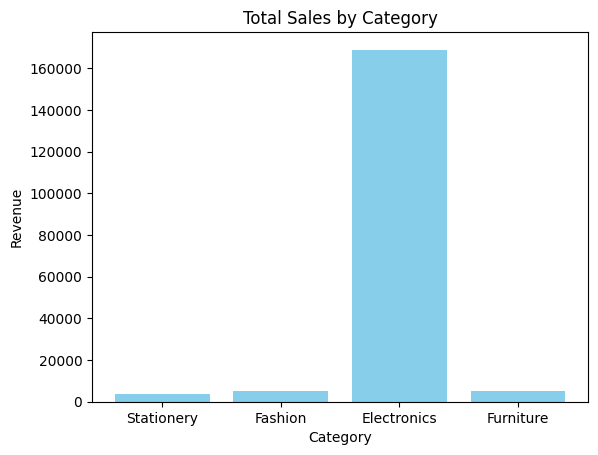

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
region_df = orders_total_df.groupBy("category").sum("total_price").toPandas()
plt.bar(region_df["category"], region_df["sum(total_price)"], color="skyblue")
plt.title("Total Sales by Category")
plt.xlabel("Category")
plt.ylabel("Revenue")
plt.show()